Predicting Defaults in Fannie Mae Loans
===

A default is a failure to meet the legal obligations (or conditions) of a particular debt obligation. In the case of home loans, a default occurs when a homebuyer fails to to meet a mortgage payment, whether it's because of forgetfulness or genuine financial inability. Regardless of the reason, defaults are costly to the owner of the loan, and predicting whether a borrower will default is the goal of credit risk models that banks use. 

This notebook explores the Fannie Mae Single-Family Loan Book dataset to answer two questions: 
1. What initial borrower information predicts an eventual default? This question will be answered visually with a connection of data visualizations of likely predictors, and significance tests of these predictors on the foreclosure status.
2. How accurate are standard machine-learning models at predicting defaults? This will be answered using K-fold cross validations of multiple models.

The notebook will begin by giving an overview of the raw dataset and the steps taken to prepare the dataset for analysis. It will then proceed with a description of likely predictors and comparative visualizations that illustrate how they differ between default & no-default borrowers, and a statistical significance test of the coefficients of each predictor when a Logit model is fitted on them. Next, two common machine learning classification models, Logistic Regression and Random Forests, will be used in K-fold cross validations. The results of the cross validations will be displayed for both models, and the results will be compared. The notebook will conclude with a discussion on the practical applications of these models and future directions to take this study in.

Data Overview
===

Beginning in 2013, Fannie Mae began releasing loan acquisition and performance data of a portion of its book of loans that it either owns or guarantees. The entire dataset spans loans that began in 2000 to the most recent quarter available, and includes close to 22 million records. The dataset is a "subset of Fannie Mae’s 30-year, fixed-rate, fully documented, single-family amortizing loans," according to <a href="http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html">Fannie Mae's webpage</a> on the data. We'll be working with a subset of this data, specifically data for loans originating between 2012 and 2015.

Data Cleaning Steps
===

Before the running of this notebook's code, the data was acquired and cleaned. Loan Acquisition & Performance data was downloaded from the Fannie Mae web database as txt files for all quarters between 2012 Q1 to 2015 Q4. All of the Acquisition data is small enough to be read in memory, so it was all joined together vertically and written to a CSV file. The Performance data was too large to be kept in memory (on an 8 GB machine), so the files were read line-by-line, and a new smaller table was created that indicated whether there was at least one default for each borrower. This new small table was written to a CSV file. Both the new Acquisition and Performance CSV files were then read into memory and merged on borrower id, resulting in a dataset that contains a column indicating whether a borrower eventually defaults and the acquisition columns.



Variable Dictionary
===

* **Foreclosure**- Binary variable that indicates whether the borrower forecloses on the loan
* **Combined Loan-to-Value (CLTV)**- Ratio of the value of the loan to the value of the asset (house, in this case). A home loan with a 20% down payment will have an initial LTV of 0.80. A "Combined" LTV factors in the original home loan and any other subordinate loans put towards the home.
* **Borrower Credit Score**- The borrower's credit score at the time of loan origination
* **Debt-to-Income (DTI)**- Ratio of the borrower's total monthly obligations to stable income
* **Interest Rate**- The interest rate of the loan at origination
* **Balance**- The balance of the loan at origination
* **First Time Homebuyer**- Binary variable that indicating whether the borrower is a first time homebuyer
* **Occupancy Status**- Classification variable that indicates how the borrower is using the home. The variable can either be Principal (it's the home they live in), Secondary (it's a vacation or secondary house), or Investor (they rent the house)
* **Single Borrower**- Derived binary variable indicating whether the borrower is alone in paying off the loan or has multiple people obligated to pay the loan.
* **Loan Purpose**- Classification variable that indicates the loan's purpose, whether it's to purchase a house or refinance
* **Channel**- Classification variable that indicates which channel the loan originated from. The standard channel will be through a retail mortgage broker (like your local bank branch), but it could also be through an entity that is not a mortgage loan seller.


Variables not used in the predictions (such as borrower zip code) were not included in this list.

Work in Progress :)

In [1]:
import pandas as pd
import settings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # ignore warning for odd numpy/statsmodels VisibleDeprecationWarning in KDE plot

Import the cleaned training dataset

In [2]:
train_df = pd.read_csv('%s/train.csv' % settings.PROCESSED_DIR, header=0)
train_df = train_df[~train_df['foreclosure_status'].isnull()]

Create categorical groupby DataFrame for categorical bar plotting

In [3]:
cat_vars = ['channel','loan_purpose','first_time_homebuyer', 'borrower_count', 'occupancy_status']
groupby_frames = {}

for v in cat_vars:
    # Calculate the total count of each foreclosure_status & categorical variable combination
    groupby_frames[v] = train_df.groupby(['foreclosure_status',v])[v].count()

    # Calculate percentage share of foreclosure_status-level percentage of each facet of the categorical variable
    groupby_frames[v] =  groupby_frames[v].groupby(level=0).apply(lambda x: x/float(x.sum()))
    groupby_frames[v] = pd.DataFrame(groupby_frames[v])
    groupby_frames[v].columns = ['share']

    # Flatten groupby frame to prepare for bar plot
    groupby_frames[v] = groupby_frames[v].reset_index()

In [7]:
print(groupby_frames['borrower_count'])

  foreclosure_status  borrower_count         share
0              False             1.0  4.793471e-01
1              False             2.0  5.162493e-01
2              False             3.0  3.464239e-03
3              False             4.0  9.250200e-04
4              False             5.0  5.955576e-06
5              False             6.0  7.623137e-06
6              False             8.0  7.146691e-07
7               True             1.0  7.595288e-01
8               True             2.0  2.390852e-01
9               True             3.0  1.386001e-03


Produce KDE pair plots for the continuous variables, and bar plots for the categorical variables

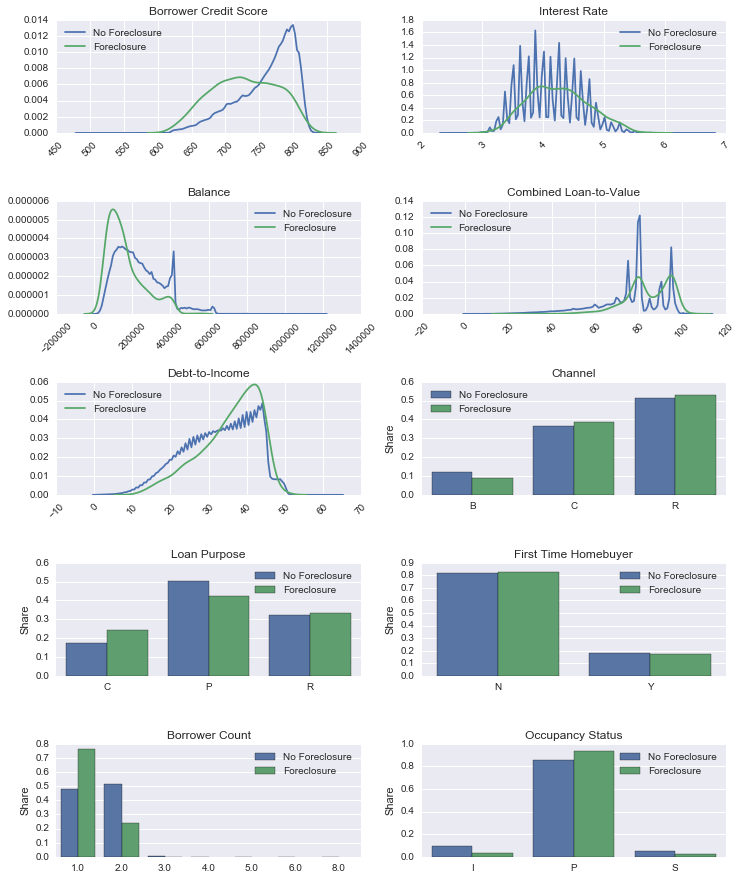

In [8]:
def kde_pair_subplot(ax, var_name, title):
    for tf in [False, True]:
        data = train_df.ix[train_df['foreclosure_status'] == tf, var_name]
        data = data[~data.isnull()]
        sns.kdeplot(data, legend=False, ax=ax)
    sns.plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    labels = ['No Foreclosure', 'Foreclosure']
    if (ax == ax1) or (ax == ax4) or (ax == ax5):
        ax.legend(handles, labels, loc='upper left')
    else:
        ax.legend(handles, labels)
        
def share_bar_subplot(ax, var_name, title):
    data = groupby_frames[var_name]
    sns.barplot(x=var_name, y='share', hue='foreclosure_status', data=data, ax=ax)
    sns.plt.setp(ax.get_xticklabels(), rotation=0)

    # Set title and ylabel
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Share')

    # Set legends for each plot
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:2]
    labels = ['No Foreclosure','Foreclosure']
    if ax == ax6: # the legend in the first bar plot will overlap with the bars if it's left in the upper right
        ax.legend(handles, labels, loc='upper left')
    else:
        ax.legend(handles, labels)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = sns.plt.subplots(5,2)
kde_axs = [ax1, ax2, ax3, ax4, ax5]
kde_vars = ['borrower_credit_score', 'interest_rate', 'balance', 'cltv', 'dti']
kde_titles = ['Borrower Credit Score', 'Interest Rate', 'Balance', 'Combined Loan-to-Value', 'Debt-to-Income']

cat_axs = [ax6, ax7, ax8, ax9, ax10]
cat_vars = ['channel','loan_purpose','first_time_homebuyer', 'borrower_count', 'occupancy_status']
cat_titles = ['Channel', 'Loan Purpose', 'First Time Homebuyer', 'Borrower Count', 'Occupancy Status']

for ax,var,title in zip(kde_axs, kde_vars, kde_titles):
    kde_pair_subplot(ax, var, title)

for ax,var,title in zip(cat_axs, cat_vars, cat_titles):
    share_bar_subplot(ax,var,title)
    
f.subplots_adjust(hspace=0.6, wspace=0.2)
f.set_size_inches(12, 15)
sns.plt.show()

Let's get an initial peek at what matters in determining the foreclosure rate. We'll use the Logit model from statsmodels to get z statistics & p values for each predictor coefficient.

In [17]:
import statsmodels.api as sm

# Specify labels and features to use for classification models
label = 'foreclosure_status_True'
features = ['score_div_cltv','borrower_credit_score','cltv','interest_rate', 'dti', 'balance_log', 'first_time_homebuyer_Y',
            'channel_C','channel_R', 'loan_purpose_C','loan_purpose_P', 'single_borrower_Y', 'occupancy_status_I',
            'occupancy_status_P']

# Fit the Logit model
logit = sm.Logit(train_df[label], sm.add_constant(train_df[features]))
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.002762
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     foreclosure_status_True   No. Observations:              4199190
Model:                               Logit   Df Residuals:                  4199175
Method:                                MLE   Df Model:                           14
Date:                     Thu, 11 Aug 2016   Pseudo R-squ.:                  0.1047
Time:                             20:37:29   Log-Likelihood:                -11597.
converged:                            True   LL-Null:                       -12952.
                                             LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                      8.7723      0.867     10.114      0.000         7.072    10.472
score_div_cltv             0.0134      0.015      0.879      0.380        -0.017     0.043
borrower_credit_score     -0.0108      0.001    -16.823      0.000        -0.012    -0.010
cltv                       0.0805      0.004     21.206      0.000         0.073     0.088
interest_rate             -0.1962      0.058     -3.368      0.001        -0.310    -0.082
dti                        0.0310      0.003      8.933      0.000         0.024     0.038
balance_log               -1.3225      0.049    -26.719      0.000        -1.420    -1.226
first_time_homebuyer_Y    -0.5242      0.085     -6.164      0.000        -0.691    -0.357
channel_C                  0.0839      0.099      0.845      0.398        -0.111     0.278
channel_R                  0.0062      0.097      0.064      0.949        -0.184     0.196
loan_purpose_C             0.2905      0.076      3.802      0.000         0.141     0.440
loan_purpose_P            -1.0580      0.075    -14.186      0.000        -1.204    -0.912
single_borrower_Y          0.7966      0.063     12.568      0.000         0.672     0.921
occupancy_status_I        -0.4444      0.220     -2.021      0.043        -0.875    -0.013
occupancy_status_P         0.3985      0.174      2.288      0.022         0.057     0.740
==========================================================================================

Possibly complete quasi-separation: A fraction 0.44 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Most of the predictors are statistically significant, as expected. I was surprised the score_div_cltv predictor wasn't significant, since that one was suggested in the Fannie Mae data tutorials on http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html.

Next we'll use scikit-learn's LogisticRegression model and cross_val_predict function to train & cross-validate a Logistic Regression model. Then we'll calcualte some binary classification performance metrics.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_predict

# Create a LogRet model, then cross validate the model on the training dataset using cross_val_predict
logistic_model = LogisticRegression(class_weight='balanced')
logistic_predictions = cross_val_predict(logistic_model, train_df[features], train_df[label], cv=4)

# Evaluate logistic regression model with accuracy score, a confusion matrix, and a classification report
print('Logistic Regression Accuracy Score: %s' %metrics.accuracy_score(train_df[label], logistic_predictions))

print('Logistic Regression Confusion Matrix:')
print(metrics.confusion_matrix(train_df[label], logistic_predictions))

print('Logistic Regression Classification Report:')
print(metrics.classification_report(logistic_predictions, train_df[label]))

Logistic Regression Accuracy Score: 0.752699687321
Logistic Regression Confusion Matrix:
[[3159565 1038182]
 [    279    1164]]
Logistic Regression Classification Report:
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86   3159844
        1.0       0.81      0.00      0.00   1039346

avg / total       0.77      0.75      0.65   4199190



Now let's see if a Random Forest Classifier gives us more accurate predictions

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(max_depth=10, n_estimators=40, class_weight='balanced')
forest_predictions = cross_val_predict(forest_model, train_df[features], train_df[label], cv=4)

# Evaluate logistic regression model with accuracy score, a confusion matrix, and a classification report
print('Random Forest Accuracy Score: %s' %metrics.accuracy_score(train_df[label], forest_predictions))

print('Random Forest Confusion Matrix:')
print(metrics.confusion_matrix(train_df[label], forest_predictions))

print('Random Forest Classification Report:')
print(metrics.classification_report(forest_predictions, train_df[label]))

Random Forest Accuracy Score: 0.875484319595
Random Forest Confusion Matrix:
[[3675530  522217]
 [    648     795]]
Random Forest Classification Report:
             precision    recall  f1-score   support

        0.0       0.88      1.00      0.93   3676178
        1.0       0.55      0.00      0.00    523012

avg / total       0.84      0.88      0.82   4199190



It appears the Random Forest classifer is a more accurate predictor than the Logistic Regression classifier.